In [4]:
#import pandas
import pandas as pd

#import the col function
from pyspark.sql.functions import col

In [5]:
# Read xlsx file into DataFrame df
xls = pd.ExcelFile('../../data/external-raw-data/crime_by_LGA.xlsx')
df = pd.read_excel(xls, 'Table 01')

In [6]:
# Preprocessing for crime data file
# Change the Local Government Area column of crime data to UPPER case for merge
df['Local Government Area'] = df['Local Government Area'].str.upper()

# Only remain the 2022 data
df = df[df['Year'] == 2022]

# Only remain the useful column which are Local Government Area, Incidents Recorded and Rate per 100,000 population
df_select = df[["Local Government Area", "Incidents Recorded","Rate per 100,000 population"]]

In [9]:
# download lga convert postcode table
# ref: https://greenash.net.au/thoughts/2014/07/australian-lga-to-postcode-mappings-with-postgis-and-intersects/
import gdown
url_convert = 'https://drive.google.com/uc?id=1phfJSEVdWOdt8PQGtw_QmWkT2uYLk_j1'
output_convert = '../../data/external-raw-data/lga_postcode_table.xlsx'
gdown.download(url_convert, output_convert, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1phfJSEVdWOdt8PQGtw_QmWkT2uYLk_j1
To: /Users/yinanli/Documents/GitHub/generic-real-estate-consulting-project-group-7/data/external-raw-data/lga_postcode_table.xlsx
100%|█████████████████████████████████████████| 101k/101k [00:00<00:00, 605kB/s]


'../../data/external-raw-data/lga_postcode_table.xlsx'

In [10]:
# Read xlsx file into DataFrame df
xls_convert = pd.ExcelFile('../../data/external-raw-data/lga_postcode_table.xlsx')
df_convert = pd.read_excel(xls_convert, 'lga_postcode_mappings')

In [11]:
# Only remain the data of Victoria
df_convert = df_convert[df_convert['State'] =='Victoria']
df_convert = df_convert[df_convert['Postcode']< 4000]
df_convert = df_convert[df_convert['Postcode']>= 3000]

# Change the LGA region column of convertion file to UPPER case for merge
df_convert['LGA region'] = df_convert['LGA region'].str.upper().str.strip()
df_convert.reset_index()

In [13]:
# make sure Local Government Area and LGA region are the same data type
df_select.loc[:,"Local Government Area"] = df_select["Local Government Area"].astype(str).str.strip()
df_convert.loc[:,"LGA region"] = df_convert["LGA region"].astype(str).str.strip()

# inner merge by Local Government Area and LGA region
df = df_convert.merge(df_select, left_on='LGA region', right_on='Local Government Area', how='inner')

/var/folders/7v/v1gh4ksn641cv86zx_w_yd840000gp/T/ipykernel_87185/224504681.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_select.loc[:,"Local Government Area"] = df_select["Local Government Area"].astype(str).str.strip()


In [14]:
# Only remain the postcode and criminal rate columns
df = df[["Postcode", "Rate per 100,000 population"]]

In [15]:
df

,Postcode,"Rate per 100,000 population"
0,3678,2827.301615
1,3691,2827.301615
2,3695,2827.301615
3,3697,2827.301615
4,3698,2827.301615
...,...,...
1488,3490,4788.492747
1489,3491,4788.492747
1490,3507,4788.492747
1491,3531,4788.492747


<AxesSubplot:>

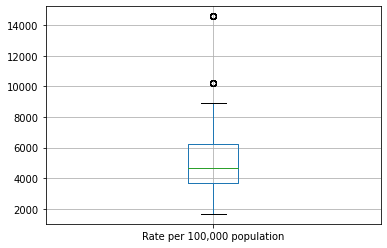

In [16]:
# draw the boxplot to see the skew to consider group by method
df.boxplot(column=['Rate per 100,000 population'])

# calculate the mean of the criminal rate column
df['Rate per 100,000 population'].mean()

# we decide use median to group by by postcode
df = df.groupby('Postcode')['Rate per 100,000 population'].median()

In [23]:
# Save to csv
df.to_csv("../../data/raw/external-data/criminal.csv")